In [1]:
from llm_manager import get_llm_instance
from langgraph.graph import START, END, StateGraph
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict

from langgraph.checkpoint.memory import InMemorySaver

F:\GenAI\LangGraph_OpenSource\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. LLM 

In [2]:
llm = get_llm_instance()

Initializing LLM: mistralai/Mistral-7B-Instruct-v0.2...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.03s/it]
Device set to use cuda


LLM initialization complete for mistralai/Mistral-7B-Instruct-v0.2.


F:\GenAI\LangGraph_OpenSource\llm_manager.py:29: UserWarning: LLMManager is already initialized. Returning existing instance.
  warnings.warn("LLMManager is already initialized. Returning existing instance.")


# 2. Parser

In [3]:
output_parser = StrOutputParser()

# 3. State Define

In [4]:
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

# 4. Node Create

In [5]:
def generateJoke(state: JokeState):
    topic = state['topic']
    prompt = PromptTemplate(
        template="""
        Generate a short joke about the topic {topic}
        """, input_variables = ['topic']
    )
    
    chain = prompt | llm | output_parser
    
    joke = chain.invoke({'topic': topic})
    return {"joke": joke}

In [6]:
def explanationGenerate(state: JokeState):
    joke = state['joke']
    prompt = PromptTemplate(
        template="""
        Generate a brief explanation of the joke {joke}
        """, input_variables = ['joke']
    )
    
    chain = prompt | llm | output_parser
    
    explanation = chain.invoke({'joke': joke})
    return {"explanation": explanation}

# 5. Graph Create

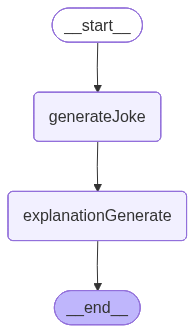

In [7]:
graph = StateGraph(JokeState)

graph.add_node('generateJoke', generateJoke)
graph.add_node('explanationGenerate', explanationGenerate)

graph.add_edge(START, 'generateJoke')
graph.add_edge('generateJoke', 'explanationGenerate')
graph.add_edge('explanationGenerate', END)

# Memory
checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)
workflow

# i) Configurable 1

In [8]:
config1 = {'configurable': {
    "thread_id" : 1
}}

workflow.invoke({'topic': "pizza"}, config = config1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'topic': 'pizza',
 'joke': '<s> [INST] \n        Generate a short joke about the topic pizza\n         [/INST] Why don\'t some types of pizza get invited to parties?\nBecause they\'re too pie-shy! (Pizza-shy is a play on words, as "pie-shy" sounds like "pizza" but means timid in the context of parties)',
 'explanation': '<s> [INST] \n        Generate a brief explanation of the joke <s> [INST] \n        Generate a short joke about the topic pizza\n         [/INST] Why don\'t some types of pizza get invited to parties?\nBecause they\'re too pie-shy! (Pizza-shy is a play on words, as "pie-shy" sounds like "pizza" but means timid in the context of parties)\n         [/INST] I hope that brought a smile to your face! Let me know if you\'d like to hear another joke or if there\'s something else I can help you with. Have a great day! 😊'}

#### state return

In [9]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': '<s> [INST] \n        Generate a short joke about the topic pizza\n         [/INST] Why don\'t some types of pizza get invited to parties?\nBecause they\'re too pie-shy! (Pizza-shy is a play on words, as "pie-shy" sounds like "pizza" but means timid in the context of parties)', 'explanation': '<s> [INST] \n        Generate a brief explanation of the joke <s> [INST] \n        Generate a short joke about the topic pizza\n         [/INST] Why don\'t some types of pizza get invited to parties?\nBecause they\'re too pie-shy! (Pizza-shy is a play on words, as "pie-shy" sounds like "pizza" but means timid in the context of parties)\n         [/INST] I hope that brought a smile to your face! Let me know if you\'d like to hear another joke or if there\'s something else I can help you with. Have a great day! 😊'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d2ab1-f67f-6c9b-8002-90e3ebee2589'}}, metad

#### state history return

In [10]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': '<s> [INST] \n        Generate a short joke about the topic pizza\n         [/INST] Why don\'t some types of pizza get invited to parties?\nBecause they\'re too pie-shy! (Pizza-shy is a play on words, as "pie-shy" sounds like "pizza" but means timid in the context of parties)', 'explanation': '<s> [INST] \n        Generate a brief explanation of the joke <s> [INST] \n        Generate a short joke about the topic pizza\n         [/INST] Why don\'t some types of pizza get invited to parties?\nBecause they\'re too pie-shy! (Pizza-shy is a play on words, as "pie-shy" sounds like "pizza" but means timid in the context of parties)\n         [/INST] I hope that brought a smile to your face! Let me know if you\'d like to hear another joke or if there\'s something else I can help you with. Have a great day! 😊'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d2ab1-f67f-6c9b-8002-90e3ebee2589'}}, meta

# ii) Configure 2

In [11]:
config2 = {'configurable': {
    "thread_id" : 2
}}

workflow.invoke({'topic': "pasta"}, config = config2)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'topic': 'pasta',
 'joke': "<s> [INST] \n        Generate a short joke about the topic pasta\n         [/INST] Why don't pasta like rainy days?\n\nBecause it makes them all soggy and faded, just like their jokes! But don't worry, this pasta is always here to serve up a side of laughter! #PastaJokes #PastaLovesSunshine",
 'explanation': '<s> [INST] \n        Generate a brief explanation of the joke <s> [INST] \n        Generate a short joke about the topic pasta\n         [/INST] Why don\'t pasta like rainy days?\n\nBecause it makes them all soggy and faded, just like their jokes! But don\'t worry, this pasta is always here to serve up a side of laughter! #PastaJokes #PastaLovesSunshine\n         [/INST] That\'s a cute pasta joke! It\'s a play on words where "pasta" refers to both the Italian dish and the third person singular pronoun. The punchline "makes them all soggy and faded" can be interpreted as both a description of what happens to pasta in the rain and a commentary on the hum

#### state return

In [12]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': "<s> [INST] \n        Generate a short joke about the topic pasta\n         [/INST] Why don't pasta like rainy days?\n\nBecause it makes them all soggy and faded, just like their jokes! But don't worry, this pasta is always here to serve up a side of laughter! #PastaJokes #PastaLovesSunshine", 'explanation': '<s> [INST] \n        Generate a brief explanation of the joke <s> [INST] \n        Generate a short joke about the topic pasta\n         [/INST] Why don\'t pasta like rainy days?\n\nBecause it makes them all soggy and faded, just like their jokes! But don\'t worry, this pasta is always here to serve up a side of laughter! #PastaJokes #PastaLovesSunshine\n         [/INST] That\'s a cute pasta joke! It\'s a play on words where "pasta" refers to both the Italian dish and the third person singular pronoun. The punchline "makes them all soggy and faded" can be interpreted as both a description of what happens to pasta in the rain and a co

#### state history return

In [13]:

for obj in list(workflow.get_state_history(config2)):
    print(obj)
    print("-----------------------------------------------------------")


StateSnapshot(values={'topic': 'pasta', 'joke': "<s> [INST] \n        Generate a short joke about the topic pasta\n         [/INST] Why don't pasta like rainy days?\n\nBecause it makes them all soggy and faded, just like their jokes! But don't worry, this pasta is always here to serve up a side of laughter! #PastaJokes #PastaLovesSunshine", 'explanation': '<s> [INST] \n        Generate a brief explanation of the joke <s> [INST] \n        Generate a short joke about the topic pasta\n         [/INST] Why don\'t pasta like rainy days?\n\nBecause it makes them all soggy and faded, just like their jokes! But don\'t worry, this pasta is always here to serve up a side of laughter! #PastaJokes #PastaLovesSunshine\n         [/INST] That\'s a cute pasta joke! It\'s a play on words where "pasta" refers to both the Italian dish and the third person singular pronoun. The punchline "makes them all soggy and faded" can be interpreted as both a description of what happens to pasta in the rain and a co

# Backtrack

In [19]:
# get a particular state
workflow.get_state({'configurable': {
    "thread_id" : "1",
    "checkpoint_id" : "1f0d2ab2-41d1-6856-8001-b83305b6b995"
}})

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0d2ab2-41d1-6856-8001-b83305b6b995'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [20]:
workflow.invoke(None, config={'configurable': {
    "thread_id" : "1",
    "checkpoint_id" : "1f0d2ab2-41d1-6856-8001-b83305b6b995"
}})

EmptyInputError: Received no input for __start__

In [21]:
# get a particular history of state
list(workflow.get_state_history({'configurable': {
    "thread_id" : "1",
    "checkpoint_id" : "1f0d2ab2-41d1-6856-8001-b83305b6b995"
}}))

[]

### Update the state

In [22]:
workflow.update_state({'configurable': {
    "thread_id" : "1",
    "checkpoint_id" : "1f0d2ab2-41d1-6856-8001-b83305b6b995",
    "checkpoint_ns": ""
}},
    {"topic": "Samosa"}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d2ab7-a153-6f8b-8000-adbd9e4e702f'}}